In [1]:
import os
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
from datetime import datetime
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss, coint, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib
from arch.unitroot import PhillipsPerron
from typing import List

In [2]:
FIRST_SLICE_DATE: datetime = datetime.strptime('11/4/2019', '%d/%m/%Y')
SECOND_SLICE_DATE: datetime = datetime.strptime('1/5/2020', '%d/%m/%Y')
THIRD_SLICE_DATE: datetime = datetime.strptime('30/11/2020', '%d/%m/%Y')

In [3]:
def transform_date_series(df: pd.DataFrame, date_key: str) -> pd.DataFrame:
    dff: pd.DataFrame = df.copy()
    dff.loc[:, date_key] = pd.to_datetime(dff.loc[:, date_key], unit='s')
    
    return dff.set_index(date_key)

In [4]:
def filter_series(df: pd.DataFrame, slice1: datetime, slice2: datetime) -> pd.DataFrame:
    dff: pd.DataFrame = df.copy()
    dff.loc[:, :] = dff[dff.index > slice1]
    dff.loc[:, :] = dff[dff.index < slice2]

    return dff.dropna()

In [5]:
def print_adf(df: pd.DataFrame, key: str) -> None:
    series = df.loc[:, key].values

    adf_test = adfuller(series, autolag='AIC')
    p_value = adf_test[1]

    dfResults = pd.Series(adf_test[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    #Add Critical Values
    for key,value in adf_test[4].items():
        dfResults[f'Critical Value ({key})'] = value

    print('Augmented Dickey-Fuller Test Results:')
    print(dfResults)

In [6]:
def print_kpss(df: pd.DataFrame, key: str) -> None:
    series = df.loc[:, key].values

    statistic, p_value, n_lags, critical_gasValue = kpss(series, nlags="auto", regression='c')
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')

    for key, value in critical_gasValue.items():
        print(f'   {key} : {value}')

# GAS series

Loading and cleaning gas data.

In [7]:
gas: pd.DataFrame = pd.read_csv(os.path.join('..', '..', 'data', 'avg_gas_price.csv'), header=0)
gas.rename(columns={'UnixTimeStamp': 'date', 'Value (Wei)': 'gasValue'}, inplace = True)
gas = gas[['date', 'gasValue']].dropna()
gas = transform_date_series(df=gas, date_key='date')

## Original series

Let's see how the series looks like.

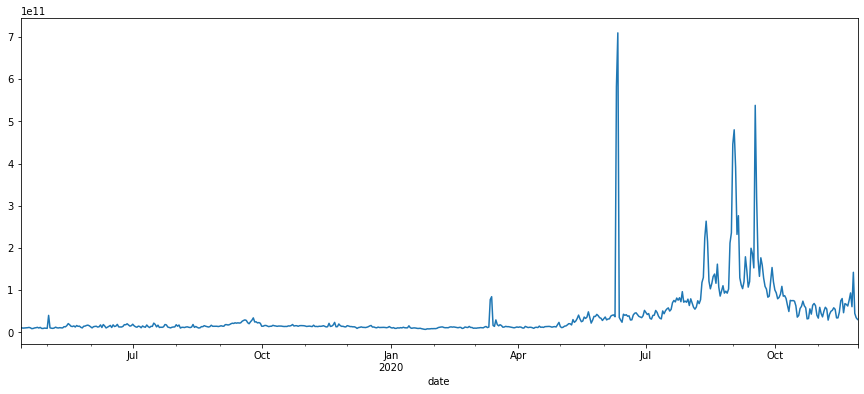

In [8]:
gas_plot = filter_series(df=gas, slice1=FIRST_SLICE_DATE, slice2=THIRD_SLICE_DATE)
gas_plot['gasValue'].plot(figsize = (15, 6))
plt.show()

## Splitting the series

We can see there is two-stage in the series. The first stage ends around May first of 2020, from then the series changed. So let's split the series into two slices. 

In [9]:
gas_slice1 = filter_series(df=gas, slice1=FIRST_SLICE_DATE, slice2=SECOND_SLICE_DATE)
gas_slice1['gasValue'] = np.log(gas_slice1['gasValue'] / gas_slice1['gasValue'].shift(1))
gas_slice1.dropna(inplace=True)

In [10]:
gas_slice2 = filter_series(df=gas, slice1=SECOND_SLICE_DATE, slice2=THIRD_SLICE_DATE)
gas_slice2['gasValue'] = np.log(gas_slice2['gasValue'] / gas_slice2['gasValue'].shift(1))
gas_slice2.dropna(inplace=True)

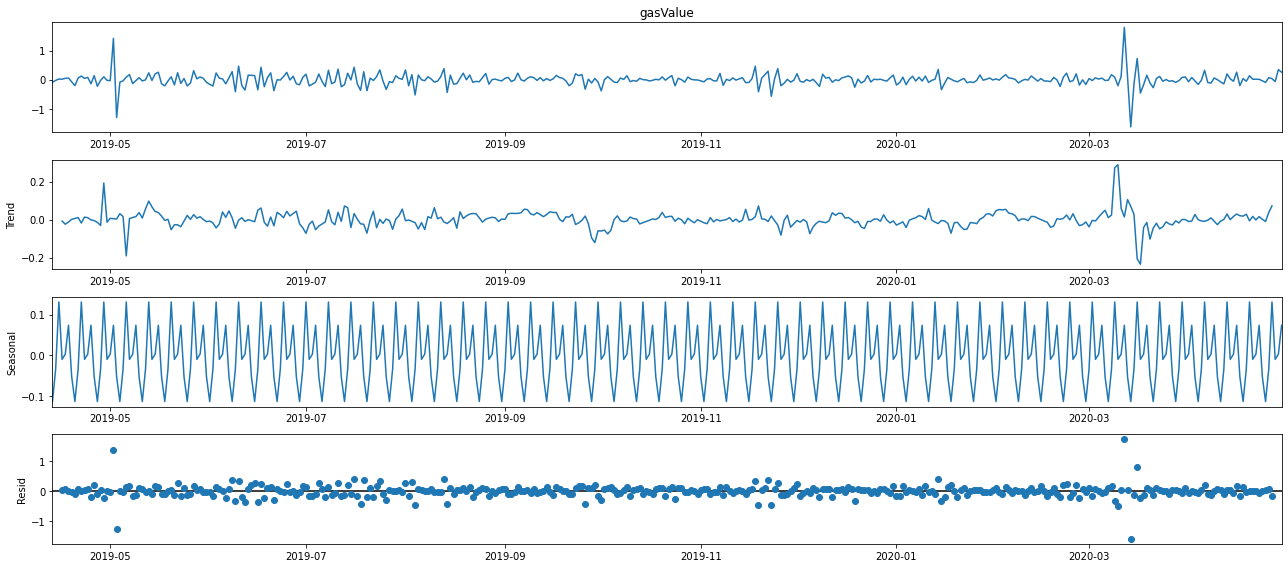

In [11]:
rcParams['figure.figsize'] = 18, 8
decomposition1 = sm.tsa.seasonal_decompose(x=gas_slice1['gasValue'], model='additive')
fig = decomposition1.plot()
plt.show()

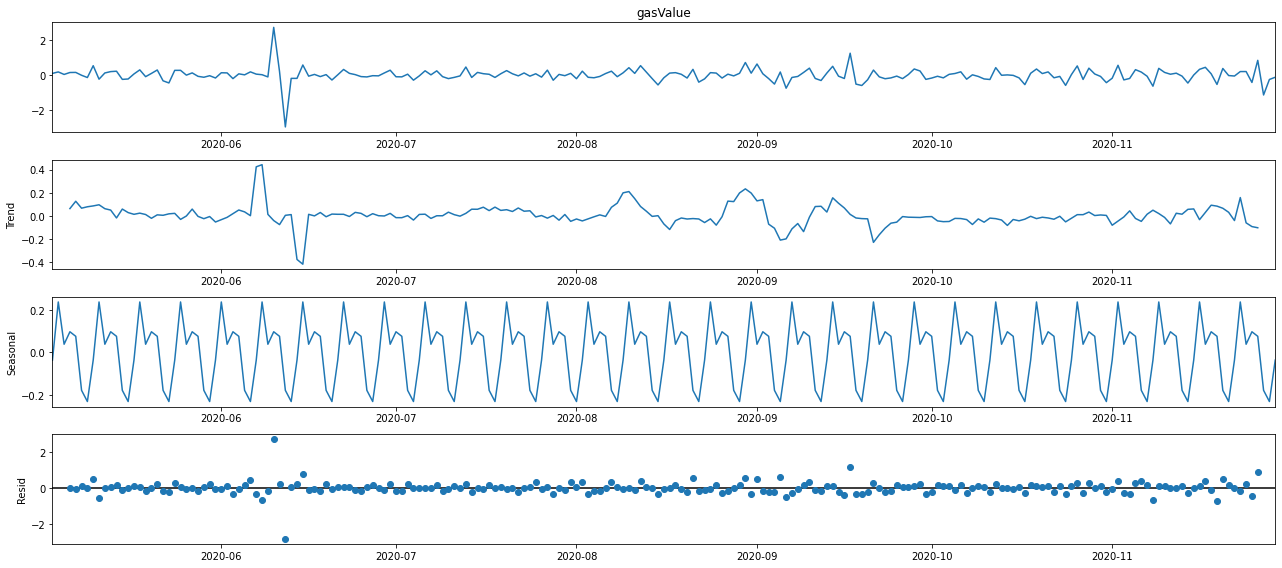

In [12]:
rcParams['figure.figsize'] = 18, 8
decomposition2 = sm.tsa.seasonal_decompose(x=gas_slice2['gasValue'], model='additive')
fig = decomposition2.plot()
plt.show()

In [13]:
gas_slice1['gasValue'] = gas_slice1['gasValue'] - decomposition1.seasonal

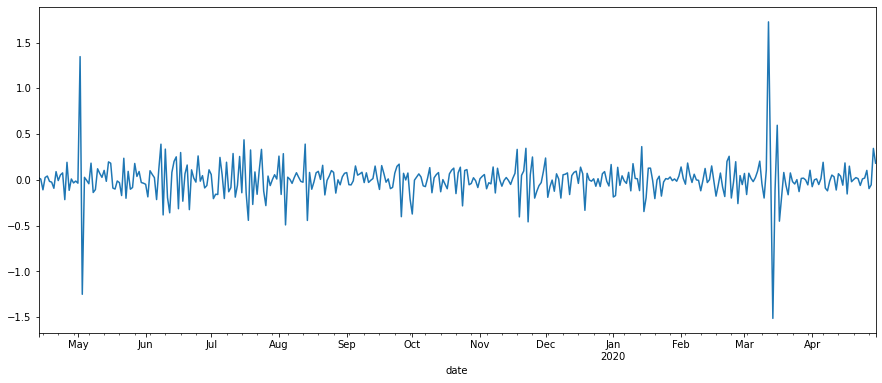

In [14]:
gas_slice1['gasValue'].plot(figsize = (15, 6))
plt.show()

In [15]:
gas_slice2['gasValue'] = gas_slice2['gasValue'] - decomposition2.seasonal

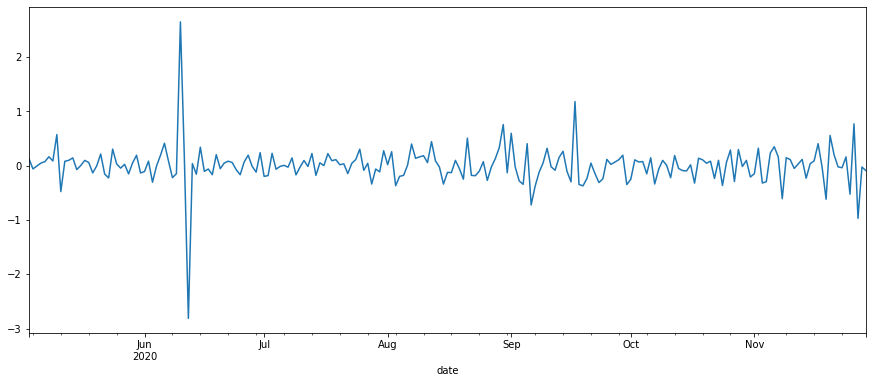

In [16]:
gas_slice2['gasValue'].plot(figsize = (15, 6))
plt.show()

## Augmented Dickey-Fuller

Let's test both series with augmented Dickey-Fuller test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [17]:
print_adf(df=gas_slice1, key='gasValue')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.395551e+01
P-Value                 4.619334e-26
# Lags Used             3.000000e+00
# Observations Used     3.800000e+02
Critical Value (1%)    -3.447676e+00
Critical Value (5%)    -2.869176e+00
Critical Value (10%)   -2.570838e+00
dtype: float64


In [18]:
print_adf(df=gas_slice2, key='gasValue')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -7.222292e+00
P-Value                 2.096094e-10
# Lags Used             9.000000e+00
# Observations Used     2.010000e+02
Critical Value (1%)    -3.463309e+00
Critical Value (5%)    -2.876029e+00
Critical Value (10%)   -2.574493e+00
dtype: float64


## Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

Where:

    * H0: The process is trend stationary.
    * H1: The series has a unit root (series is not stationary).

In [19]:
print_kpss(df=gas_slice1, key='gasValue')

KPSS Statistic: 0.13000982214734969
p-value: 0.1
num lags: 67
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [20]:
print_kpss(df=gas_slice2, key='gasValue')

KPSS Statistic: 0.3048552805078578
p-value: 0.1
num lags: 33
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


## Phillips–Perron (PP) test

Let's test both series with augmented Phillips–Perron test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [21]:
pp = PhillipsPerron(gas_slice1['gasValue'])
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -37.549
P-value                         0.000
Lags                               17
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [22]:
pp = PhillipsPerron(gas_slice2['gasValue'])
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -22.713
P-value                         0.000
Lags                               15
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.88 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


# DAOstack activity series

Let's check what about the activity series.

In [23]:
daostack: pd.DataFrame = pd.read_csv(os.path.join('..', '..', 'data', 'daostack_activity.csv'), header=0)
daostack = transform_date_series(df=daostack, date_key='date')

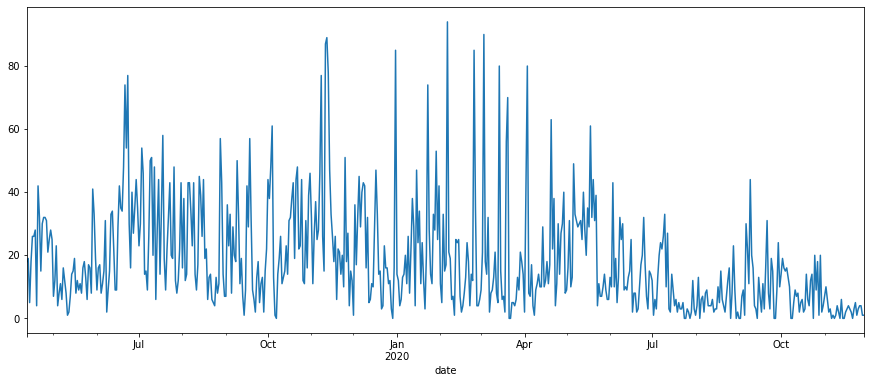

In [24]:
daostack_plot = filter_series(df=daostack, slice1=FIRST_SLICE_DATE, slice2=THIRD_SLICE_DATE)
daostack_plot['actions'].plot(figsize = (15, 6))
plt.show()

## Spliting the series

As we previously do with the gas series, let's split the series.

In [25]:
daostack_slice1 = filter_series(df=daostack, slice1=FIRST_SLICE_DATE, slice2=SECOND_SLICE_DATE)
daostack_slice1.drop(daostack_slice1.index[0], inplace=True)

In [26]:
daostack_slice2 = filter_series(df=daostack, slice1=SECOND_SLICE_DATE, slice2=THIRD_SLICE_DATE)
daostack_slice2.drop(daostack_slice2.index[0], inplace=True)

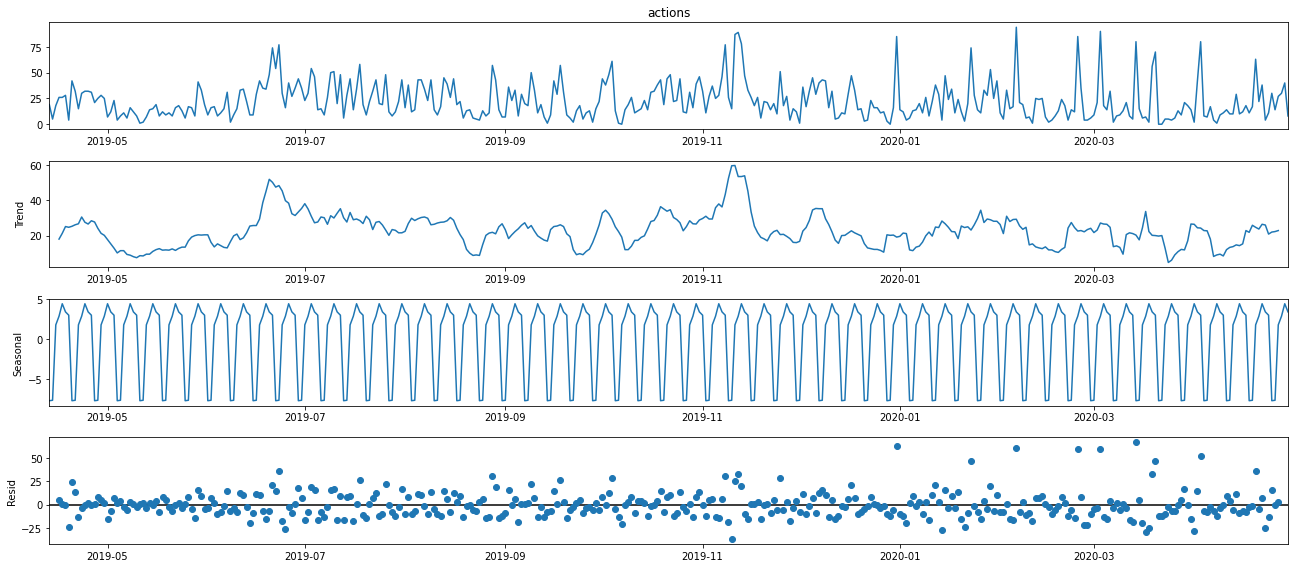

In [27]:
rcParams['figure.figsize'] = 18, 8
decomposition1 = sm.tsa.seasonal_decompose(x=daostack_slice1['actions'], model='additive')
fig = decomposition1.plot()
plt.show()

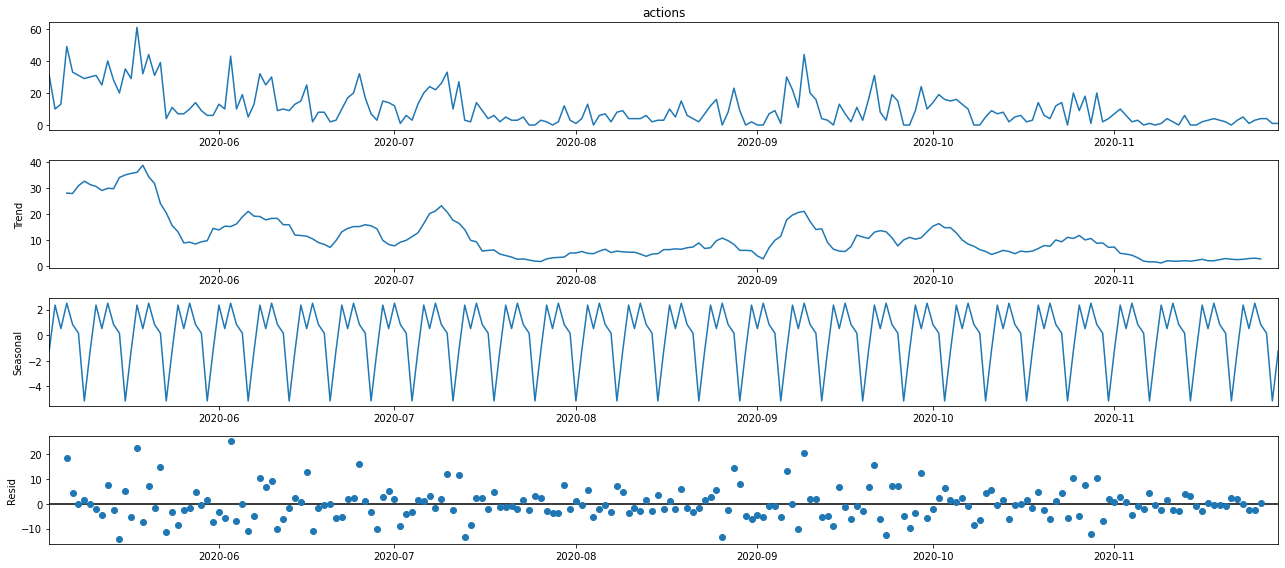

In [28]:
rcParams['figure.figsize'] = 18, 8
decomposition2 = sm.tsa.seasonal_decompose(x=daostack_slice2['actions'], model='additive')
fig = decomposition2.plot()
plt.show()

In [29]:
daostack_slice1['actions'] = daostack_slice1['actions'] - decomposition1.seasonal

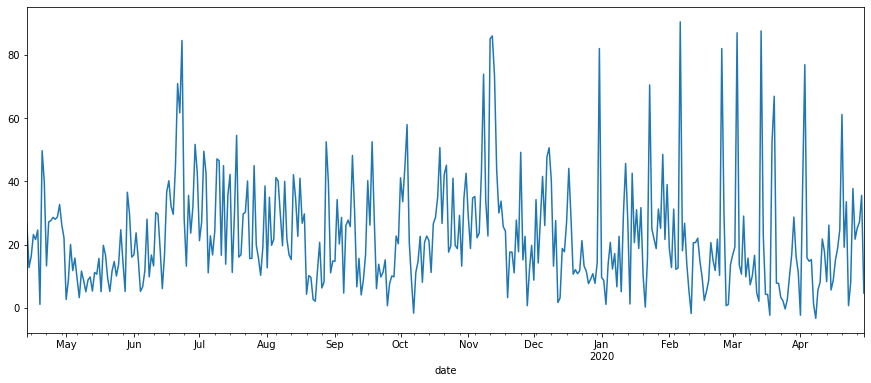

In [30]:
daostack_slice1['actions'].plot(figsize = (15, 6))
plt.show()

In [31]:
daostack_slice2['actions'] = daostack_slice2['actions'] - decomposition2.seasonal

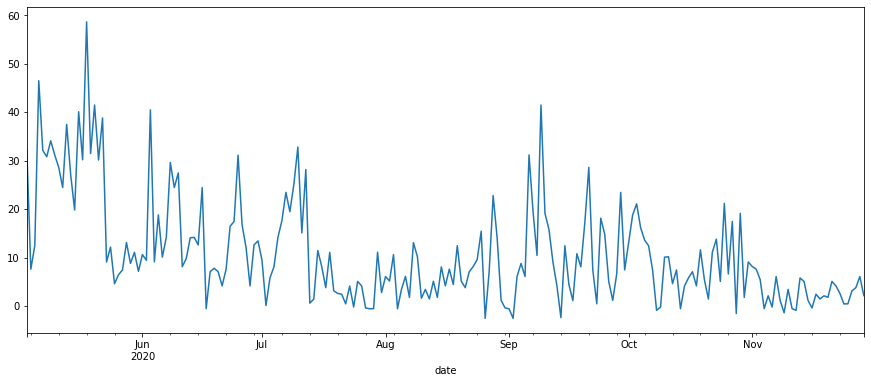

In [32]:
daostack_slice2['actions'].plot(figsize = (15, 6))
plt.show()

## Augmented Dickey-Fuller

Let's test both series with augmented Dickey-Fuller test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [33]:
print_adf(df=daostack_slice1, key='actions')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.425516e+01
P-Value                 1.458227e-26
# Lags Used             0.000000e+00
# Observations Used     3.830000e+02
Critical Value (1%)    -3.447540e+00
Critical Value (5%)    -2.869116e+00
Critical Value (10%)   -2.570806e+00
dtype: float64


In [34]:
print_adf(df=daostack_slice2, key='actions')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.624657
P-Value                   0.000116
# Lags Used               1.000000
# Observations Used     209.000000
Critical Value (1%)      -3.462032
Critical Value (5%)      -2.875471
Critical Value (10%)     -2.574195
dtype: float64


## Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

Where:

    * H0: The process is trend stationary.
    * H1: The series has a unit root (series is not stationary).

In [35]:
print_kpss(df=daostack_slice1, key='actions')

KPSS Statistic: 0.20280969446386854
p-value: 0.1
num lags: 7
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [36]:
print_kpss(df=daostack_slice2, key='actions')

KPSS Statistic: 1.1074160323147193
p-value: 0.01
num lags: 8
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1881: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


## Phillips–Perron (PP) test

Let's test both series with augmented Phillips–Perron test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [37]:
pp = PhillipsPerron(daostack_slice1['actions'])
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -15.338
P-value                         0.000
Lags                               17
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [38]:
pp = PhillipsPerron(daostack_slice2['actions'])
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -9.282
P-value                         0.000
Lags                               15
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.88 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


# Granger Causality Tests

Where:

    * H0: The second column, x2, does NOT Granger cause the time series in the first column, x1
    * H1: x2 Granger cause x1

In [39]:
slice1: pd.DataFrame = pd.DataFrame(
    {'actions': daostack_slice1['actions'].tolist(),
     'gasValue': gas_slice1['gasValue'].tolist(),
    })
    
gc_res1 = grangercausalitytests(slice1, 5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2186  , p=0.6404  , df_denom=380, df_num=1
ssr based chi2 test:   chi2=0.2203  , p=0.6388  , df=1
likelihood ratio test: chi2=0.2202  , p=0.6389  , df=1
parameter F test:         F=0.2186  , p=0.6404  , df_denom=380, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2664  , p=0.1051  , df_denom=377, df_num=2
ssr based chi2 test:   chi2=4.5930  , p=0.1006  , df=2
likelihood ratio test: chi2=4.5656  , p=0.1020  , df=2
parameter F test:         F=2.2664  , p=0.1051  , df_denom=377, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9868  , p=0.1155  , df_denom=374, df_num=3
ssr based chi2 test:   chi2=6.0719  , p=0.1082  , df=3
likelihood ratio test: chi2=6.0240  , p=0.1104  , df=3
parameter F test:         F=1.9868  , p=0.1155  , df_denom=374, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.4894  , p=0.0430  

In [40]:
slice2: pd.DataFrame = pd.DataFrame(
    {'actions': daostack_slice2['actions'].tolist(),
     'gasValue': gas_slice2['gasValue'].tolist(),
    })
    
gc_res2 = grangercausalitytests(slice2, 5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0063  , p=0.9368  , df_denom=207, df_num=1
ssr based chi2 test:   chi2=0.0064  , p=0.9363  , df=1
likelihood ratio test: chi2=0.0064  , p=0.9363  , df=1
parameter F test:         F=0.0063  , p=0.9368  , df_denom=207, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8311  , p=0.1629  , df_denom=204, df_num=2
ssr based chi2 test:   chi2=3.7520  , p=0.1532  , df=2
likelihood ratio test: chi2=3.7187  , p=0.1558  , df=2
parameter F test:         F=1.8311  , p=0.1629  , df_denom=204, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5624  , p=0.1997  , df_denom=201, df_num=3
ssr based chi2 test:   chi2=4.8505  , p=0.1831  , df=3
likelihood ratio test: chi2=4.7949  , p=0.1875  , df=3
parameter F test:         F=1.5624  , p=0.1997  , df_denom=201, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3646  , p=0.2476  

# VAR analysis

## Slice 1

In [41]:
slice1: pd.DataFrame = gas_slice1.copy(deep=True)
slice1['actions'] = daostack_slice1['actions'].tolist()

In [42]:
model1 = VAR(slice1)
model1.select_order(10).summary()

/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,2.599,2.620,13.45,2.607
1,2.448,2.511,11.56,2.473
2,2.316,2.421*,10.14,2.358*
3,2.301*,2.448,9.984*,2.359
4,2.306,2.495,10.04,2.381
5,2.313,2.544,10.10,2.404
6,2.319,2.592,10.17,2.428
7,2.334,2.649,10.32,2.459
8,2.353,2.709,10.51,2.494
9,2.341,2.740,10.40,2.500


In [43]:
results1 = model1.fit(maxlags=2, ic='bic')
results1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 15, Jan, 2021
Time:                     13:24:27
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    2.39768
Nobs:                     382.000    HQIC:                   2.33537
Log likelihood:          -1512.30    FPE:                    9.91845
AIC:                      2.29439    Det(Omega_mle):         9.66381
--------------------------------------------------------------------
Results for equation gasValue
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.005439         0.018883            0.288           0.773
L1.gasValue        -0.346515         0.048647           -7.123           0.000
L1.actions         -0.000238         0.000602           -0.395   

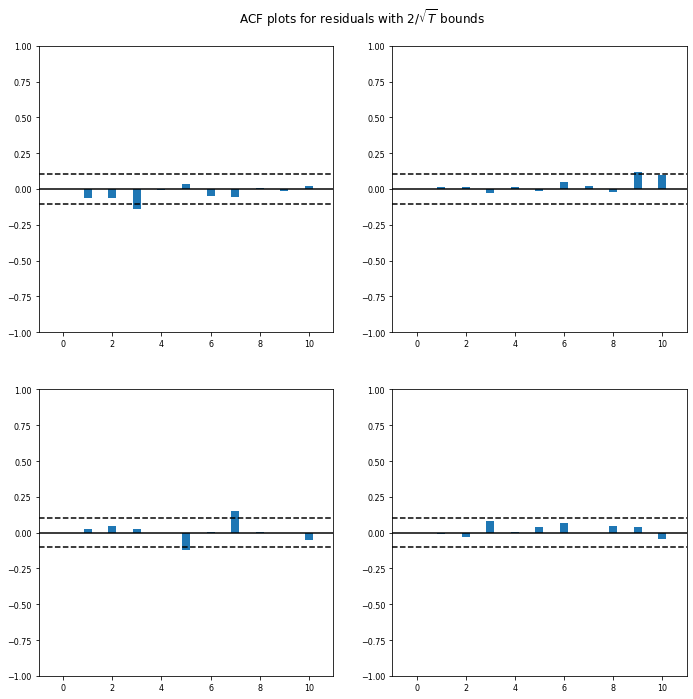

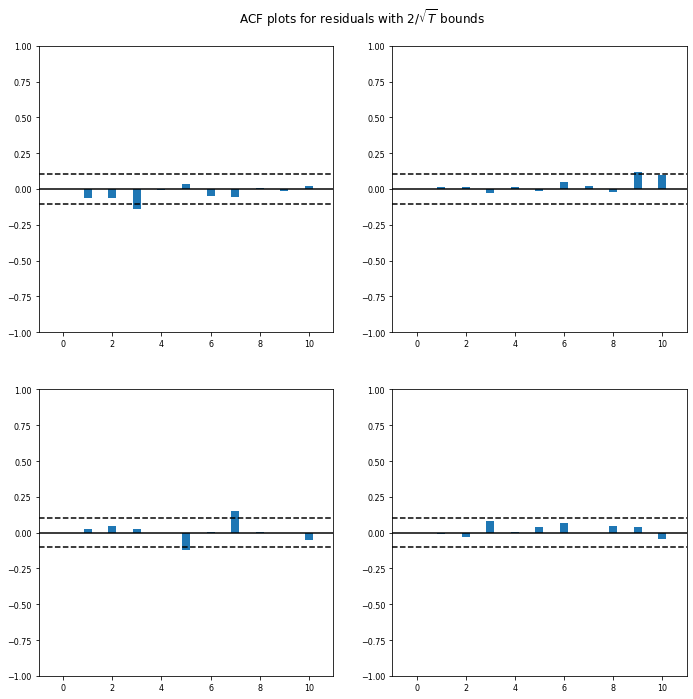

In [44]:
results1.plot_acorr()

### Impulse Response

In [45]:
irf1 = results1.irf(20)

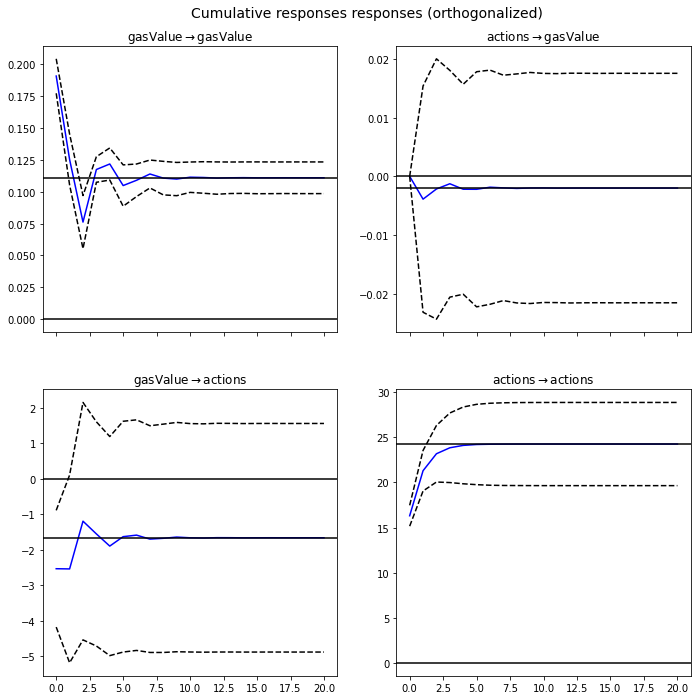

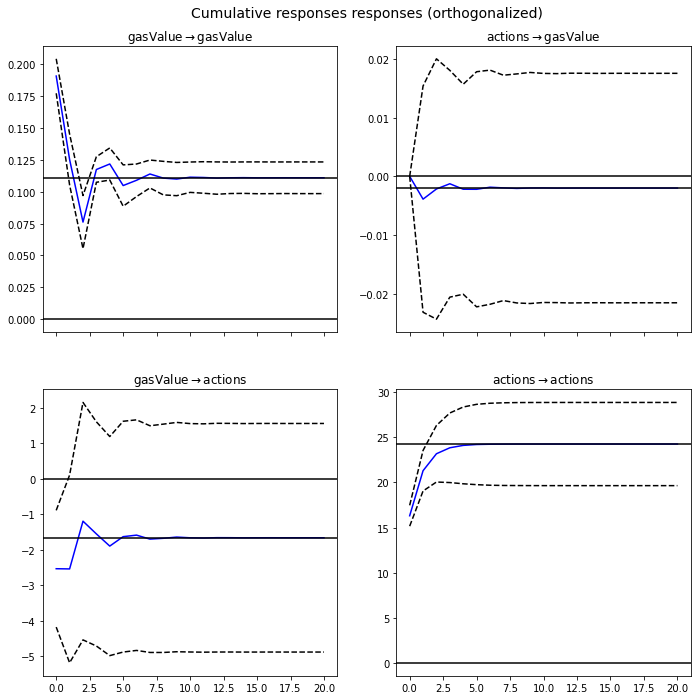

In [46]:
irf1.plot_cum_effects(orth=True)

In [47]:
results1.fevd(periods=20).summary()

FEVD for gasValue
      gasValue   actions
0     1.000000  0.000000
1     0.999630  0.000370
2     0.999582  0.000418
3     0.999580  0.000420
4     0.999561  0.000439
5     0.999563  0.000437
6     0.999561  0.000439
7     0.999561  0.000439
8     0.999561  0.000439
9     0.999561  0.000439
10    0.999561  0.000439
11    0.999561  0.000439
12    0.999561  0.000439
13    0.999561  0.000439
14    0.999561  0.000439
15    0.999561  0.000439
16    0.999561  0.000439
17    0.999561  0.000439
18    0.999561  0.000439
19    0.999561  0.000439

FEVD for actions
      gasValue   actions
0     0.023566  0.976434
1     0.021588  0.978412
2     0.027189  0.972811
3     0.027564  0.972436
4     0.027934  0.972066
5     0.028159  0.971841
6     0.028164  0.971836
7     0.028205  0.971795
8     0.028206  0.971794
9     0.028210  0.971790
10    0.028211  0.971789
11    0.028212  0.971788
12    0.028212  0.971788
13    0.028212  0.971788
14    0.028212  0.971788
15    0.028212  0.971788
16    0.028212

In [48]:
results1.test_normality().summary()

Test statistic,Critical value,p-value,df
9343.,9.488,0.000,4


In [49]:
results1.test_whiteness(nlags=20).summary()

Test statistic,Critical value,p-value,df
78.10,92.81,0.291,72


In [50]:
results1.test_inst_causality(causing='gasValue').summary()

Test statistic,Critical value,p-value,df
8.795,3.841,0.003,1


In [51]:
results1.test_causality(caused='actions',causing='gasValue').summary()

Test statistic,Critical value,p-value,df
2.266,3.008,0.104,"(2, 754)"


## Slice 2

In [52]:
slice2: pd.DataFrame = gas_slice2.copy(deep=True)
slice2['actions'] = daostack_slice2['actions'].tolist()

In [53]:
model2 = sm.tsa.VAR(slice2)
model2.select_order(10).summary()

/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,2.662,2.695,14.32,2.675
1,2.336,2.435,10.34,2.376
2,2.109*,2.273*,8.239*,2.175*
3,2.123,2.353,8.360,2.217
4,2.153,2.449,8.612,2.273
5,2.189,2.551,8.931,2.336
6,2.214,2.641,9.152,2.386
7,2.192,2.685,8.958,2.392
8,2.181,2.740,8.864,2.407
9,2.117,2.742,8.319,2.370


In [54]:
results2 = model2.fit(maxlags=2, ic='bic')
results2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 15, Jan, 2021
Time:                     13:24:29
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    2.32601
Nobs:                     209.000    HQIC:                   2.23075
Log likelihood:          -809.473    FPE:                    8.72430
AIC:                      2.16609    Det(Omega_mle):         8.32138
--------------------------------------------------------------------
Results for equation gasValue
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.023245         0.036625           -0.635           0.526
L1.gasValue        -0.150692         0.066548           -2.264           0.024
L1.actions          0.003068         0.002722            1.127   

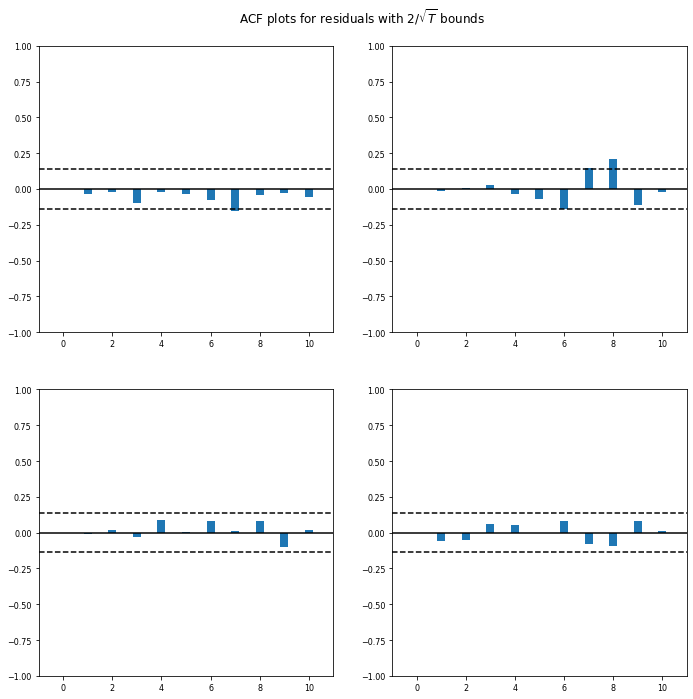

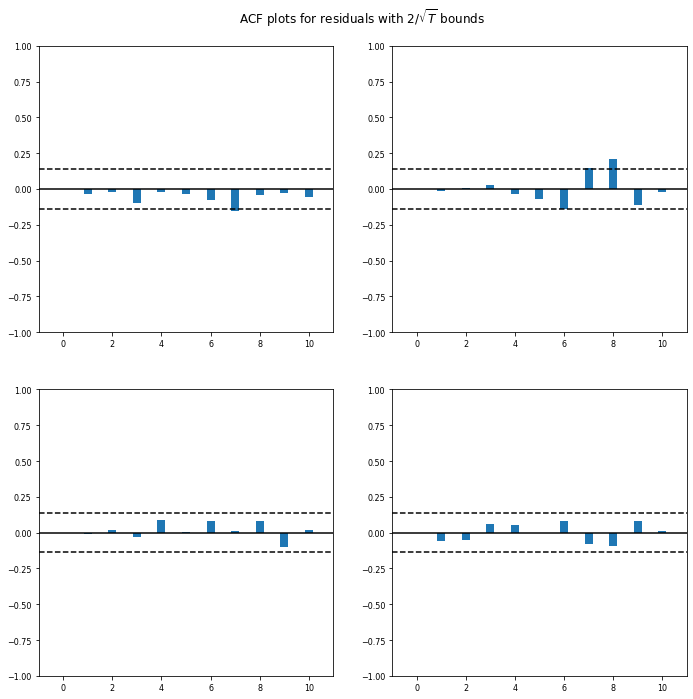

In [55]:
results2.plot_acorr()

### Impulse Response

In [56]:
irf2 = results2.irf(20)

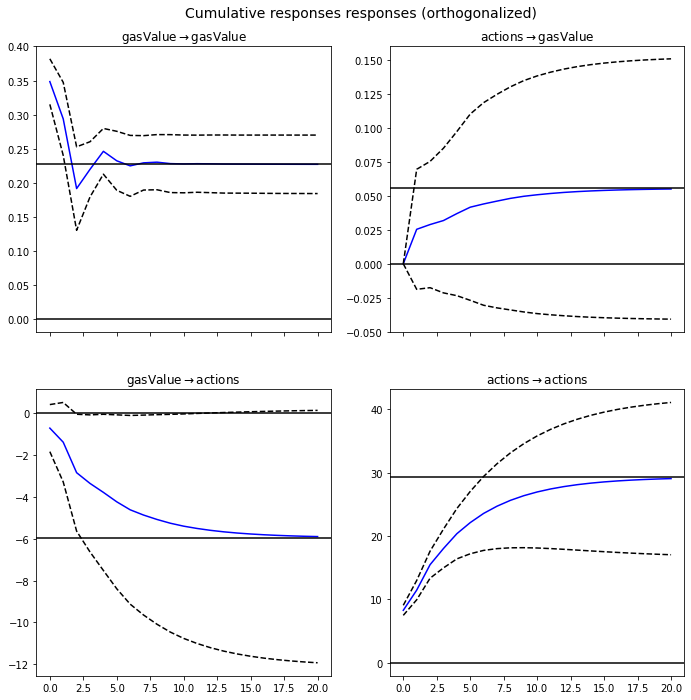

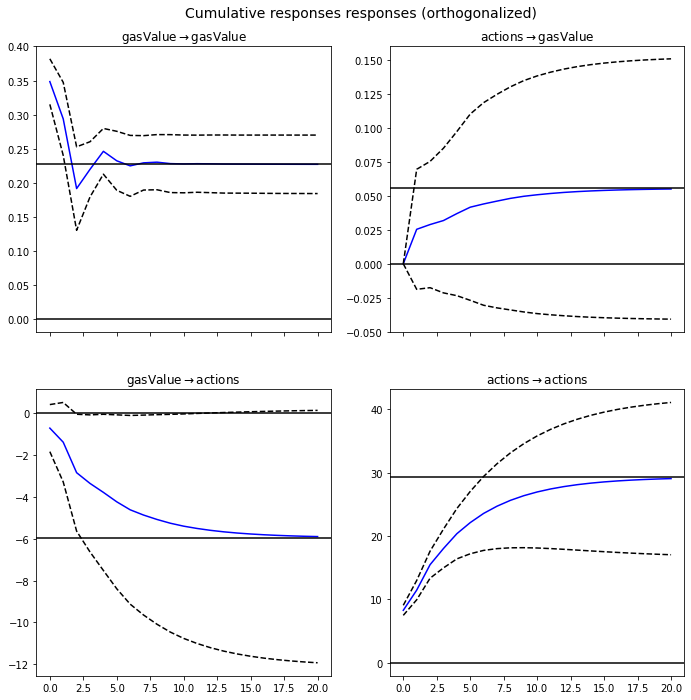

In [57]:
irf2.plot_cum_effects(orth=True)

In [58]:
results2.fevd(periods=20).summary()

FEVD for gasValue
      gasValue   actions
0     1.000000  0.000000
1     0.994840  0.005160
2     0.995148  0.004852
3     0.995112  0.004888
4     0.994948  0.005052
5     0.994792  0.005208
6     0.994753  0.005247
7     0.994722  0.005278
8     0.994693  0.005307
9     0.994676  0.005324
10    0.994666  0.005334
11    0.994660  0.005340
12    0.994656  0.005344
13    0.994653  0.005347
14    0.994651  0.005349
15    0.994650  0.005350
16    0.994649  0.005351
17    0.994649  0.005351
18    0.994649  0.005351
19    0.994649  0.005351

FEVD for actions
      gasValue   actions
0     0.007413  0.992587
1     0.012119  0.987881
2     0.031523  0.968477
3     0.031998  0.968002
4     0.032021  0.967979
5     0.032893  0.967107
6     0.033507  0.966493
7     0.033657  0.966343
8     0.033774  0.966226
9     0.033886  0.966114
10    0.033949  0.966051
11    0.033982  0.966018
12    0.034006  0.965994
13    0.034022  0.965978
14    0.034032  0.965968
15    0.034038  0.965962
16    0.034042

In [59]:
results2.test_normality().summary()

Test statistic,Critical value,p-value,df
2965.,9.488,0.000,4


In [60]:
results2.test_whiteness(nlags=20).summary()

Test statistic,Critical value,p-value,df
90.80,92.81,0.067,72


In [61]:
results2.test_inst_causality(causing='gasValue').summary()

Test statistic,Critical value,p-value,df
1.538,3.841,0.215,1


In [62]:
results2.test_causality(caused='actions',causing='gasValue').summary()

Test statistic,Critical value,p-value,df
1.831,3.018,0.162,"(2, 408)"
